In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import transformers
from transformers import AutoConfig, AutoTokenizer
from transformers import T5ForConditionalGeneration

In [2]:
# !pip install sentencepiece
# T5 Tokenizer is based on SentencePiece

In [2]:
MODEL_NAME = "KETI-AIR/ke-t5-large"

config = AutoConfig.from_pretrained(MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, config=config)
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, config=config)

In [3]:
wiki = pd.read_json("/opt/ml/data/wikipedia_documents.json").T
wiki.head()

,text,corpus_source,url,domain,title,author,html,document_id
0,"이 문서는 나라 목록이며, 전 세계 206개 나라의 각 현황과 주권 승인 정보를 개...",위키피디아,TODO,None,나라 목록,None,None,0
1,이 목록에 실린 국가 기준은 1933년 몬테비데오 협약 1장을 참고로 하였다. 협정...,위키피디아,TODO,None,나라 목록,None,None,1
2,현 서울특별시 종로구 서린동 (구 일제 강점기 경기도 경성부 서린정) 출신이다. 친...,위키피디아,TODO,None,백남준,None,None,2
3,"아오조라 문고(靑空文庫, あおぞらぶんこ|아오조라 분고)는 ‘일본어판 구텐베르크 프로...",위키피디아,TODO,None,아오조라 문고,None,None,3
4,저자 사망 이후 50년이 지나 저작권이 소멸한 메이지 시대부터 쇼와 시대 초기까지의...,위키피디아,TODO,None,아오조라 문고,None,None,4


In [4]:
tokenizer.SPECIAL_TOKENS_ATTRIBUTES

['bos_token',
 'eos_token',
 'unk_token',
 'sep_token',
 'pad_token',
 'cls_token',
 'mask_token',
 'additional_special_tokens']

In [5]:
tokenizer.convert_ids_to_tokens(1)

'</s>'

In [16]:
# QUERY_WORDS = ["대한민국", "국가", "나라"]
# query = "</s>".join(QUERY_WORDS)

query = "잉글랜드어가 지구적 언어가 된 시기는?"
QUERY_WORDS = ["잉글랜드", "언어", "시기"]

# query = "사탕수수 생산을 경제의 근간으로 하는 국가는?" + "</s>"
# QUERY_WORDS = ["사탕수수", "생산", "경제", "국가"]

# query = "영리를 목적으로 하지 않고 소규모로 운영되는 PC통신 서비스는?" 
# QUERY_WORDS = ["비영리", "소규모", "PC", "통신"]
# ANSWER_WORDS = ["사설", "BBS"]
# 사설 BBS 개인 또는 단체가 운영하는 주로 비영리 목적의 소규모 PC통신 서비스였다

# query = "불규칙해 보이지만, 전체적인 모습과 가지 하나하나가 비슷한 수학적 구조는?"
# QUERY_WORDS = ["불규칙", "전체", "가지", "구조"]
# ANSWER_WORDS = ["프랙탈"]

# query = "현대건설이 다양한 건설 및 복원 사업을 수주하여 국내 건설업체 중 도급한도액이 1위를 차지한 연도는?"
# QUERY_WORDS = ["현대", "건설", "복원", "도급한도액", "1위"]
# ANSWER_WORDS = ["1960년"]
# 그 뒤 낙동강 고령교 복구, 한강 인도교 복구, 제1한강교 복구, 인천 제1도크 복구 등의 사업을 수주하여 1960년에는 국내 건설업체중 도급한도액이 1위를 차지하게 되었다.
# document_id: 41

# query = "우리 나라 오백원짜리 지폐가 처음 발행된 시기는?"
# QUERY_WORDS = ["500원", "오백원", "지폐", "발행", "시기"]
# ANSWER_WORDS = ["1971년"]


In [17]:
NUM_DOCUMENTS = 500
max_seq_len = 486
doc_stride = 128

tokenized_wikis = tokenizer(
    [query] * NUM_DOCUMENTS,
    [text.replace("\n", "").replace("  ", " ") for text in wiki['text'][0:NUM_DOCUMENTS].tolist()],
    # truncation="only_second" if pad_on_right else "only_first",
    truncation=True,
    max_length=max_seq_len,
    stride=doc_stride,
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
    return_token_type_ids=False, 
    padding='longest',
    return_tensors="pt"
    # the max length of the model is 512...
)

tokenized_query = tokenizer(
    query,
    # truncation="only_second" if pad_on_right else "only_first",
    truncation=True,
    max_length=max_seq_len,
    stride=doc_stride,
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
    return_token_type_ids=False, 
    padding='longest',
    return_tensors="pt"
)

In [10]:
model = model.to("cuda")

In [18]:
tokenized_wikis[0]

Encoding(num_tokens=486, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [19]:
tokenized_query[0]

Encoding(num_tokens=10, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [20]:
input_ids = torch.tensor(tokenized_wikis[0].ids).to("cuda")
attention_mask = torch.tensor(tokenized_wikis[0].attention_mask).to("cuda")
out = model.encoder(
    input_ids=input_ids.unsqueeze(0),
    attention_mask=attention_mask.unsqueeze(0)
)
# must unsqueeze it!

In [21]:
tokenizer.decode(input_ids)

'잉글랜드어가 지구적 언어가 된 시기는?</s> 이 문서는 나라 목록이며, 전 세계 206개 나라의 각 현황과 주권 승인 정보를 개요 형태로 나열하고 있다.이 목록은 명료화를 위해 두 부분으로 나뉘어 있다.# 첫 번째 부분은 바티칸 시국과 팔레스타인을 포함하여 유엔 등 국제 기구에 가입되어 국제적인 승인을 널리 받았다고 여기는 195개 나라를 나열하고 있다.# 두 번째 부분은 일부 지역의 주권을 사실상 (데 팍토) 행사하고 있지만, 아직 국제적인 승인을 널리 받지 않았다고 여기는 11개 나라를 나열하고 있다.두 목록은 모두 가나다 순이다.일부 국가의 경우 국가로서의 자격에 논쟁의 여부가 있으며, 이 때문에 이러한 목록을 엮는 것은 매우 어렵고 논란이 생길 수 있는 과정이다. 이 목록을 구성하고 있는 국가를 선정하는 기준에 대한 정보는 "포함 기준" 단락을 통해 설명하였다. 나라에 대한 일반적인 정보는 "국가" 문서에서 설명하고 있다.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad

In [22]:
output = model.generate(
    input_ids = input_ids.unsqueeze(0), 
    attention_mask = attention_mask.unsqueeze(0),
    num_beams=16, 
    min_length=1, 
    max_length=30, 
    early_stopping=True
)
output

tensor([[    0, 41774, 41774, 41774, 41774, 41774, 41774, 41774, 41774, 41774,
         41774, 41774, 41774, 41774, 41774, 41774, 41774, 41774, 41774, 41774,
         41774, 41774, 41774, 41774, 41774, 41774, 41774, 41774, 41774, 41774]],
       device='cuda:0')

In [23]:
tokenizer.convert_ids_to_tokens(output[0])

['<pad>',
 '▁광교',
 '▁광교',
 '▁광교',
 '▁광교',
 '▁광교',
 '▁광교',
 '▁광교',
 '▁광교',
 '▁광교',
 '▁광교',
 '▁광교',
 '▁광교',
 '▁광교',
 '▁광교',
 '▁광교',
 '▁광교',
 '▁광교',
 '▁광교',
 '▁광교',
 '▁광교',
 '▁광교',
 '▁광교',
 '▁광교',
 '▁광교',
 '▁광교',
 '▁광교',
 '▁광교',
 '▁광교',
 '▁광교']

In [24]:
out
# BaseModelOutputWithPastAndCrossAttentions

BaseModelOutputWithPastAndCrossAttentions(last_hidden_state=tensor([[[-0.0050, -0.0512,  0.0853,  ...,  0.0230, -0.0431,  0.0778],
         [-0.0041,  0.0971,  0.0401,  ...,  0.0508, -0.0854, -0.0243],
         [-0.0011, -0.1652, -0.0142,  ..., -0.0342,  0.0455,  0.0540],
         ...,
         [ 0.0145, -0.0360,  0.0223,  ..., -0.0482, -0.0024, -0.0460],
         [ 0.0145, -0.0360,  0.0223,  ..., -0.0482, -0.0024, -0.0460],
         [ 0.0145, -0.0360,  0.0223,  ..., -0.0482, -0.0024, -0.0460]]],
       device='cuda:0', grad_fn=<MulBackward0>), past_key_values=None, hidden_states=None, attentions=None, cross_attentions=None)

In [26]:
out['last_hidden_state'].shape

torch.Size([1, 486, 1024])

In [27]:
last_hidden_state = out['last_hidden_state']
last_hidden_state.shape
# batch_size, seq_length, embedding_dim

torch.Size([1, 486, 1024])

In [28]:
last_hidden_state * attention_mask.unsqueeze(0).unsqueeze(2)

tensor([[[-0.0050, -0.0512,  0.0853,  ...,  0.0230, -0.0431,  0.0778],
         [-0.0041,  0.0971,  0.0401,  ...,  0.0508, -0.0854, -0.0243],
         [-0.0011, -0.1652, -0.0142,  ..., -0.0342,  0.0455,  0.0540],
         ...,
         [ 0.0000, -0.0000,  0.0000,  ..., -0.0000, -0.0000, -0.0000],
         [ 0.0000, -0.0000,  0.0000,  ..., -0.0000, -0.0000, -0.0000],
         [ 0.0000, -0.0000,  0.0000,  ..., -0.0000, -0.0000, -0.0000]]],
       device='cuda:0', grad_fn=<MulBackward0>)

In [29]:
sum_hidden_state = torch.sum(last_hidden_state, dim=1)
sum_hidden_state.shape

torch.Size([1, 1024])

In [30]:
document_embeddings = []
for i in range(NUM_DOCUMENTS):
    with torch.no_grad():
        input_ids = torch.tensor(tokenized_wikis[i].ids).to("cuda")
        attention_mask = torch.tensor(tokenized_wikis[i].attention_mask).to("cuda")

        out = model.encoder(
            input_ids=input_ids.unsqueeze(0),
            attention_mask=attention_mask.unsqueeze(0)
        )
        # collate_fn not implemented yet

        last_hidden_state = out['last_hidden_state']
        last_hidden_state = last_hidden_state * attention_mask.unsqueeze(0).unsqueeze(2)
        # batch_size, seq_length, embedding_dim

        num_elements = torch.sum(attention_mask)

        document_embedding = torch.sum(last_hidden_state, dim=1)
        document_embedding = document_embedding / num_elements
        # batch_size, embedding_dim

        document_embeddings.append(document_embedding)

document_embeddings = torch.cat(document_embeddings, dim=0)
document_embeddings.shape

torch.Size([500, 1024])

In [31]:
document_embeddings = document_embeddings.detach().cpu().numpy()

In [32]:
document_embeddings.shape

(500, 1024)

In [33]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

N_CLUSTERS = 16

pca = PCA(n_components=128)
km  = KMeans(n_clusters=N_CLUSTERS)

In [34]:
pca_result = pca.fit_transform(document_embeddings)
pca_result.shape

(500, 128)

In [35]:
pred = km.fit_predict(pca_result)

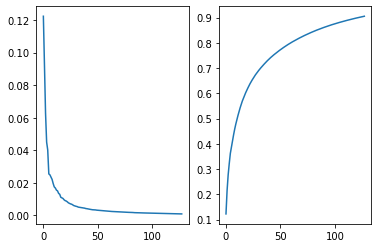

In [36]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(pca.explained_variance_ratio_)
ax[1].plot(np.cumsum(pca.explained_variance_ratio_))

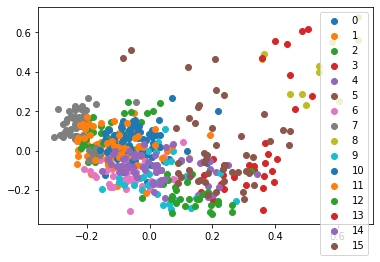

In [37]:
for c in range(N_CLUSTERS):
    i = np.where(pred == c)
    plt.scatter(pca_result[i,0], pca_result[i,1], label = c)
    
plt.legend()

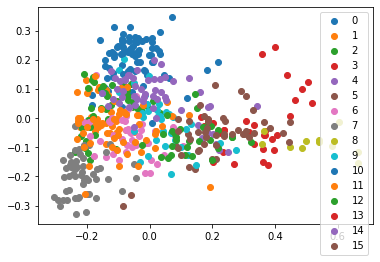

In [38]:
for c in range(N_CLUSTERS):
    i = np.where(pred == c)
    plt.scatter(pca_result[i,0], pca_result[i,2], label = c)
    
plt.legend()

In [39]:
wiki[0:NUM_DOCUMENTS][pred == 0]

,text,corpus_source,url,domain,title,author,html,document_id
37,"고대 일본에서 한자의 일부 획을 따서 문자로 삼은 것은 일찍이 7세기부터였으나, ...",위키피디아,TODO,None,가타카나,None,None,37
58,사설 BBS는 개인 또는 단체가 운영하는 주로 비영리 목적의 소규모 PC통신 서비스...,위키피디아,TODO,None,PC통신,None,None,58
59,"한편, 흔히 01410으로 알려진 한국통신하이텔은 전화망을 활용한 부가통신 서비스의...",위키피디아,TODO,None,PC통신,None,None,59
91,"하이퍼텍스트(Hypertext, 초본문, 하이퍼본문)는 참조(하이퍼링크)를 통해 독...",위키피디아,TODO,None,하이퍼텍스트,None,None,91
112,연령별로는 20대와 70대 이상에서 많은 표를 얻는 추세이다. 이 때문에 일부 ...,위키피디아,TODO,None,자유민주당 (일본),None,None,112
149,잉글랜드어는 라틴어와 프랑스어의 어휘에서 많은 영향을 받았으며 지리적 고립으로 인한...,위키피디아,TODO,None,영어,None,None,149
157,엔트로피 인코딩 혹은 엔트로피 부호화(entropy encoding)는 심볼이 나올...,위키피디아,TODO,None,엔트로피 부호화,None,None,157
158,패션 산업은 현대의 산물이다. 19세기 중반 이전에 대부분의 옷은 주문 제작 되었다...,위키피디아,TODO,None,패션,None,None,158
159,"음정(音程, interval)은 음악이론에서 두 음의 높이 차이, 즉 두 음 사이의...",위키피디아,TODO,None,음정,None,None,159
160,"이렇게 음과 음 사이의 도수가 정해졌을 때, 그 정해진 도수를 기반으로 정확한 간격...",위키피디아,TODO,None,음정,None,None,160


In [40]:
kmeans_result_query_sum = []
for c in range(N_CLUSTERS):
    kmeans_result_query_sum.append(0)
    for w in QUERY_WORDS:
        kmeans_result_query_sum[c] += np.sum(wiki['text'][0:NUM_DOCUMENTS][pred == c].str.count(w))

print(kmeans_result_query_sum)

[16, 7, 49, 0, 35, 20, 21, 37, 3, 41, 14, 16, 5, 1, 9, 13]


In [41]:
kmeans_result_query_count = []
for c in range(N_CLUSTERS):
    kmeans_result_query_count.append(0)
    for w in QUERY_WORDS:
        kmeans_result_query_count[c] += np.sum(wiki['text'][0:NUM_DOCUMENTS][pred == c].str.contains(w))

print(kmeans_result_query_count)

[7, 2, 14, 0, 4, 3, 12, 14, 3, 13, 10, 5, 5, 1, 4, 6]


In [ ]:
ANSWER_

In [528]:
kmeans_result_answer_sum = []
for c in range(N_CLUSTERS):
    kmeans_result_answer_sum.append(0)
    for w in ANSWER_WORDS:
        kmeans_result_answer_sum[c] += np.sum(wiki['text'][0:NUM_DOCUMENTS][pred == c].str.count(w))

print(kmeans_result_answer_sum)

[1, 1, 3, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 3]


In [529]:
kmeans_result_answer_count = []
for c in range(N_CLUSTERS):
    kmeans_result_answer_count.append(0)
    for w in ANSWER_WORDS:
        kmeans_result_answer_count[c] += np.sum(wiki['text'][0:NUM_DOCUMENTS][pred == c].str.contains(w))

print(kmeans_result_answer_count)

[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2]


In [42]:
wiki[0:NUM_DOCUMENTS][pred == np.argmax(kmeans_result_query_sum)]

,text,corpus_source,url,domain,title,author,html,document_id
4,저자 사망 이후 50년이 지나 저작권이 소멸한 메이지 시대부터 쇼와 시대 초기까지의...,위키피디아,TODO,None,아오조라 문고,None,None,4
8,켄 톰슨(Ken Thompson) 등과 함께 최초의 유닉스(Unix) 시스템을 개발...,위키피디아,TODO,None,데니스 리치,None,None,8
9,"주기율표(週期律表, 주기률표, periodic table) 또는 주기표(週期表)는 ...",위키피디아,TODO,None,주기율표,None,None,9
11,"아미노산(amino acid)은 생물의 몸을 구성하는 단백질의 기본 구성 단위로, ...",위키피디아,TODO,None,아미노산,None,None,11
40,가난 때문에 중학교에 진학하지 못하고 아버지의 농사를 도왔다. 가난에서 벗어나려고 ...,위키피디아,TODO,None,정주영,None,None,40
47,"2000년 5월에 명예회장직을 사퇴하였다. 1987년 제1회 한국경영대상, 1988...",위키피디아,TODO,None,정주영,None,None,47
48,1992년 11월에는 MBC 방송 일요일 일요일 밤에의 코너 진행자의 한사람인 최병...,위키피디아,TODO,None,정주영,None,None,48
49,오클라호마주 털사 태생으로 시카고 대학에서 철학을 전공하였다. 그는 유희수학(rec...,위키피디아,TODO,None,마틴 가드너,None,None,49
50,"아놀드 알로이스 슈워제네거(Arnold Alois Schwarzenegger, /...",위키피디아,TODO,None,아널드 슈워제네거,None,None,50
51,"슈워제네거는 오스트리아의 작은 마을 탈에서, 오스트리아 헌병 부사관 출신으로 지역 ...",위키피디아,TODO,None,아널드 슈워제네거,None,None,51


In [43]:
wiki[0:NUM_DOCUMENTS][pred == np.argmax(kmeans_result_query_count)]

,text,corpus_source,url,domain,title,author,html,document_id
4,저자 사망 이후 50년이 지나 저작권이 소멸한 메이지 시대부터 쇼와 시대 초기까지의...,위키피디아,TODO,None,아오조라 문고,None,None,4
8,켄 톰슨(Ken Thompson) 등과 함께 최초의 유닉스(Unix) 시스템을 개발...,위키피디아,TODO,None,데니스 리치,None,None,8
9,"주기율표(週期律表, 주기률표, periodic table) 또는 주기표(週期表)는 ...",위키피디아,TODO,None,주기율표,None,None,9
11,"아미노산(amino acid)은 생물의 몸을 구성하는 단백질의 기본 구성 단위로, ...",위키피디아,TODO,None,아미노산,None,None,11
40,가난 때문에 중학교에 진학하지 못하고 아버지의 농사를 도왔다. 가난에서 벗어나려고 ...,위키피디아,TODO,None,정주영,None,None,40
47,"2000년 5월에 명예회장직을 사퇴하였다. 1987년 제1회 한국경영대상, 1988...",위키피디아,TODO,None,정주영,None,None,47
48,1992년 11월에는 MBC 방송 일요일 일요일 밤에의 코너 진행자의 한사람인 최병...,위키피디아,TODO,None,정주영,None,None,48
49,오클라호마주 털사 태생으로 시카고 대학에서 철학을 전공하였다. 그는 유희수학(rec...,위키피디아,TODO,None,마틴 가드너,None,None,49
50,"아놀드 알로이스 슈워제네거(Arnold Alois Schwarzenegger, /...",위키피디아,TODO,None,아널드 슈워제네거,None,None,50
51,"슈워제네거는 오스트리아의 작은 마을 탈에서, 오스트리아 헌병 부사관 출신으로 지역 ...",위키피디아,TODO,None,아널드 슈워제네거,None,None,51


In [532]:
wiki[0:NUM_DOCUMENTS][pred == np.argmax(kmeans_result_answer_sum)]

,text,corpus_source,url,domain,title,author,html,document_id
14,파이의 날(Pi Day)은 원주율을 기념하는 날이다. 파이의 날은 원주율의 근삿값이...,위키피디아,TODO,None,파이의 날,None,None,14
16,"통계학은 관찰 및 조사로 얻을 수 있는 데이터로부터, 응용 수학의 기법을 이용해 수...",위키피디아,TODO,None,통계학,None,None,16
17,"영어의 statistics(통계학, 통계)는 확률을 뜻하는 라틴어의 statisti...",위키피디아,TODO,None,통계학,None,None,17
18,매우 다양한 분야의 연구에서 주어진 문제에 대하여 적절한 정보를 수집하고 분석하여 ...,위키피디아,TODO,None,통계학,None,None,18
19,조사대상을 기준으로하면 대상이 되는 통계 집단의 단위를 하나하나 전부 조사하는 관찰...,위키피디아,TODO,None,통계학,None,None,19
20,"설문지 작성은 실험계획의 일부이기도 하지만, 대개 별개의 실습을 통해 체득하여야 한...",위키피디아,TODO,None,통계학,None,None,20
24,"《자연철학의 수학적 원리》(自然哲學- 數學的原理, Philosophiae Natur...",위키피디아,TODO,None,자연철학의 수학적 원리,None,None,24
42,1971년 정주영 회장은 혼자서 미포만 해변 사진 한 장과 외국 조선소에서 빌린 유...,위키피디아,TODO,None,정주영,None,None,42
43,"기업인으로 활동하는 중에도 한국지역사회학교 후원회에 참여하여, 1969년 1월에는 ...",위키피디아,TODO,None,정주영,None,None,43
44,"1970년대부터 대한민국 주도로 88 올림픽의 서울특별시 유치 운동에 참여하였고, ...",위키피디아,TODO,None,정주영,None,None,44


In [533]:
wiki[0:NUM_DOCUMENTS][pred == np.argmax(kmeans_result_answer_count)]

,text,corpus_source,url,domain,title,author,html,document_id
4,저자 사망 이후 50년이 지나 저작권이 소멸한 메이지 시대부터 쇼와 시대 초기까지의...,위키피디아,TODO,None,아오조라 문고,None,None,4
8,켄 톰슨(Ken Thompson) 등과 함께 최초의 유닉스(Unix) 시스템을 개발...,위키피디아,TODO,None,데니스 리치,None,None,8
9,"주기율표(週期律表, 주기률표, periodic table) 또는 주기표(週期表)는 ...",위키피디아,TODO,None,주기율표,None,None,9
40,가난 때문에 중학교에 진학하지 못하고 아버지의 농사를 도왔다. 가난에서 벗어나려고 ...,위키피디아,TODO,None,정주영,None,None,40
47,"2000년 5월에 명예회장직을 사퇴하였다. 1987년 제1회 한국경영대상, 1988...",위키피디아,TODO,None,정주영,None,None,47
48,1992년 11월에는 MBC 방송 일요일 일요일 밤에의 코너 진행자의 한사람인 최병...,위키피디아,TODO,None,정주영,None,None,48
49,오클라호마주 털사 태생으로 시카고 대학에서 철학을 전공하였다. 그는 유희수학(rec...,위키피디아,TODO,None,마틴 가드너,None,None,49
50,"아놀드 알로이스 슈워제네거(Arnold Alois Schwarzenegger, /...",위키피디아,TODO,None,아널드 슈워제네거,None,None,50
51,"슈워제네거는 오스트리아의 작은 마을 탈에서, 오스트리아 헌병 부사관 출신으로 지역 ...",위키피디아,TODO,None,아널드 슈워제네거,None,None,51
52,"셀빅(CellVic)은 대한민국에서 생산했던 PDA의 일종이며, jTel에서 개발하...",위키피디아,TODO,None,셀빅,None,None,52


In [534]:
query

'우리 나라 오백원짜리 지폐가 처음 발행된 시기는?'

In [44]:
input_ids = torch.tensor(tokenized_query[0].ids).to("cuda")
query_out = model.encoder(input_ids.unsqueeze(0))
# must unsqueeze it!
last_hidden_state = query_out['last_hidden_state']
# batch_size, seq_length, embedding_dim

query_embedding = torch.mean(last_hidden_state, dim=1)
# batch_size, embedding_dim
query_embedding = query_embedding.detach().cpu().numpy()


In [45]:
query_embedding

array([[-0.01203081, -0.03174581,  0.0086933 , ...,  0.00245197,
        -0.05140926, -0.01170381]], dtype=float32)

In [46]:
query_embedding = pca.transform(query_embedding)

In [47]:
query_embedding

array([[-0.01680185, -0.3757703 , -0.02243245,  0.39378643, -0.14960551,
         0.10965015,  0.20773888, -0.10353643, -0.06989066,  0.14506906,
         0.0628583 , -0.17955089,  0.06241457,  0.04320513,  0.01422468,
        -0.16113117, -0.00142355, -0.08735973,  0.15913317,  0.1088726 ,
        -0.05319233,  0.08729379, -0.14168794,  0.0091575 ,  0.03202332,
        -0.01956525,  0.11918636,  0.06967354,  0.09075313,  0.08824143,
        -0.01226397,  0.03119472, -0.02826334, -0.04665357, -0.08386204,
         0.03480168, -0.07047923, -0.00878481,  0.08520159,  0.04651432,
         0.1627122 ,  0.01254335,  0.00458837, -0.00112345,  0.06223256,
        -0.0420715 ,  0.03088214, -0.00383145, -0.02630821, -0.03447397,
         0.09748247,  0.03130259, -0.13262028,  0.10726559, -0.04001859,
        -0.04722387, -0.02405935, -0.06981426, -0.03180911, -0.05569608,
        -0.03265547, -0.1246608 , -0.04222951, -0.08890734,  0.08441743,
        -0.02343696, -0.05043536,  0.10191932, -0.0

In [48]:
from sklearn.neighbors import KDTree

kdt = KDTree(pca_result, leaf_size=10)

In [49]:
dist, idx = kdt.query(query_embedding, k=10)

In [50]:
dist

array([[0.86233353, 0.87995092, 0.88310561, 0.88882782, 0.89421259,
        0.90104596, 0.9015708 , 0.90583333, 0.91114938, 0.91165411,
        0.91305865, 0.91949566, 0.92898764, 0.92943123, 0.93009011,
        0.93031321, 0.93125036, 0.93166634, 0.93236979, 0.93276614]])

In [51]:
wiki['title'][0:NUM_DOCUMENTS].iloc[idx.flatten()]

199           국제단위계
393          튀코 브라헤
147              영어
32              벡터곱
424       갈릴레오 갈릴레이
402          튀코 브라헤
110      자유민주당 (일본)
410            천문학사
425       갈릴레오 갈릴레이
460             강희제
381     루트비히 비트겐슈타인
186              쿠바
420       갈릴레오 갈릴레이
221           자유한국당
362     저급 프로그래밍 언어
253      루트비히 판 베토벤
384         귀스타브 모로
372    소크라테스 이전 철학자
249      루트비히 판 베토벤
189              쿠바
Name: title, dtype: object

In [498]:
wiki['text'][394]

'튀코가 관측한 별과 행성 궤도 등 여러 결과들은 양도 많을 뿐더러 모든 자료가 놀라울 정도로 정확하다.  튀코의 별 관측 목록 D에 관하여 Rawlins는 이전의 어떠한 천문학자들보다 튀코는 관측방법, 기구, 계산 등 모든 면에서 월등히 뛰어난 관측을 했다고 하였다. 그는 수년간에 걸쳐서 정확한 관측을 계속하면서 정확성은 육안으로 볼 수 있는 극한까지 이르렀고, 망원경을 사용하지 않은 관측으로는 가장 정밀하였다고 한다. 그의 정확성을 살펴본다면 그가 작성한 항성목록의 표준성좌표의 오차는 불과 25초에 지나지 않았다. 그가 오랜시간을 별의 위치를 측정하는데 바쳐 항성목록을 출판했는데 그 목록에는 777개 항성의 정확한 위치를 측정했으며 나중에는 1000개까지 늘어나게 되었다. 또한 달궤도의 각 지점의 위치를 정기적으로 측정하여 달 운동이론을 발전시키고 달궤도 귀착점의 속도를 측정하였다. 이후 천문학 발전에 있어 가장 중요한 의의를 가지는 것이 튀코 브라헤의 행성관측이었다. 당시의 정밀하지 못한 관측기구를 이용하여 가까운 항성의 이각   을 측정해내었다. 벤  섬에서 연구하던 시절에 그는 항상 자신이 만든 사분의와 혼천의를 사용하여 연구를 진행하고 있었지만 갑작스럽게 찾아온 죽음에 의해 결국 수치화된 행성이론을 만들지 못했다. 그러나 이것은 케플러에 의해 완성되었다.'

In [52]:
wiki['text'][147]

'영어권\n 근대 잉글랜드어는 종종 최초의 지구적 링구아 프랑카로서 언급된다.   잉글랜드어는 통신, 과학, 무역, 비행, 오락, 방송, 외교 등의 분야에서 국제어로서 사용되고 있다. 때문에 잉글랜드어의 사용은 종종 언어 제국주의라는 비판을 받기도 한다.  잉글랜드어는 대영제국의 팽창과 함께 브리튼 제도의 밖에서 사용되기 시작하였으며 19세기 말 무렵에는 글자 그대로 전지구적 언어가 되었다.  영국의 식민지였던 미국과 캐나다 역시 잉글랜드어 사용의 확대에 기여하였는데, 특히 제2차 세계대전 이후 초강국이 된 미국으로 인해 잉글랜드어 사용의 세계화는 더욱 확산되었다\n\n의료나 컴퓨터 사용과 같은 여러 분야는 기초적인 잉글랜드어 사용 능력을 전제로 한다. 이를 위해 수억명 이상의 사람들이 잉글랜드어를 배운다.  잉글랜드어는 유엔의 여섯 공용어 가운데 하나이다.\n\n영국의 언어학자 데이비드 크리스털은 전 지구적인 잉글랜드어 사용의 급격한 증가로 인해 다른 언어가 막대한 타격을 입고 있다고 말한다. 북아메리카와 오스트레일리아를 포함한 지구 곳곳에서 잉글랜드어 사용이 일반화됨으로써 각 지역의 자연어가 갖고 있던 언어 다양성이 감소하고 심지어 더이상 쓰는 사람이 없는 사어가 되고 있다고 지적한다.  이러한 잉글랜드어의 영향은 역사언어학의 연구에서도 확인할 수 있다. 여러 언어 공동체에 광범위하게 확산되어 사용되고 있는 잉글랜드어는 복잡하고 역동적인 언어 변화를 가져왔다. 크리올과 피진은 이러한 잉글랜드어의 영향으로 만들어진 새로운 어족이다.'

In [500]:
wiki['text'][58]

"사설 BBS는 개인 또는 단체가 운영하는 주로 비영리 목적의 소규모 PC통신 서비스였다. 자발적으로 발생한 이러한 사설 BBS들은 상용 PC통신 서비스가 대중화되기 전까지 PC통신의 개척자 역할을 하였다.\n\n대한민국 사설 BBS는 1988년 3월 이주희가 개설한 'The FIRST'과 1988년 5월 바이트전자가 개설하고 최승철이 운영한 '바이트 네트(Byte-Net)'가 효시로 알려져 있다. 곧이어 대구에서XENIX 환경에서 4개의 접속노드를 갖추어 다중접속자를 지원하는 '달구벌'이 개설되고, 이듬해에는 '엠팔(EMPal) BBS'가 개설되는데, 이 두개의 BBS는 당시 한국데이터통신에서 제공한 전자사서함 'H-mail'의 사용자들을 주축으로 만들어졌다. 또 와일드캣과 8개의 전화 회선을 이용하여 운영하는 '네트워크 서울'도 있었다.\n\n이렇게 출발한 사설 BBS들은 외국산 호스트 프로그램—주로 와일드캣—을 한글화 해서 사용했는데, 1990년 10월에 최초의 국산 호스트 프로그램인 '카페'가 조병철에 의해서 공개되었고, 이를 바탕으로 하성욱의 '곰주인', 김성철의 '밀키웨이'가 나왔고, 이와 별도로 1991년 최오길의 '호롱불'이 등장하여 전국적인 사설 BBS 네트워크가 구축되었다.\n\n당시 유명 사설 BBS는 다음과 같다.\n* 달구벌\n* 엠팔(EMPal BBS)\n* 메디네트\n* 참세상\n* 평화만들기\n*까치멀"

In [501]:
wiki['text'][164]

'1, 4, 5, 8도 음정의 경우에는 "장/단" 표기를 절대 사용하지 않고, 2, 3, 6, 7도 음정의 경우에는 "완전" 표기를 절대 사용하지 않는데, 이는 음 과 음 사이의 조화로운 울림에 영향을 끼치는 배음 과 관계가 있다.\n\n사인파 를 제외한 모든 음(音)은 실제로 하나의 음이 아닌 여러개의 음이 같이 울리는데, 이와 같이 함께 울리는 음들을 배음이라고 부르며, 인간은 그 배음들 중에서 일반적으로 가장 잘 들리는 1배음을 주로 듣기 때문에 음을 하나로 느끼는 것이다. \n\n이 배음들을 근음인 1배음 부터 12배음까지 나열해봤을 때, 각각의 배음들의 음정을 살펴보면 다음과 같다.\n\n \n* 근음 C2 와 1배음 C2 는 완전1도이다.\n* 1배음 C2 와 2배음 C3 는 완전8도이다.\n* 2배음 C3 와 3배음 G3 는 완전5도이다. (실제로 정확한 3배음은 G3 에서 +2 센트만큼 높은 음이다.)\n* 3배음 G3 와 4배음 C4 는 완전4도이다.\n* 4배음 C4 와 5배음 E4 는 장3도이다. (실제로 정확한 5배음은 E4 에서 -14 센트만큼 낮은 음이다.)\n* 5배음 E4 와 6배음 G4 는 단3도이다. (실제로 정확한 6배음은 E4 에서 +2 센트만큼 높은 음이다.)\n* 6배음 G4 와 7배음 Bb4 는 단3도이다. (실제로 정확한 7배음은 Bb4 에서 -31 센트만큼 낮은 음이다.)\n* 7배음 Bb4 와 8배음 C5 는 장2도이다.\n* 8배음 C5 와 9배음 D5 는 장2도이다. (실제로 정확한 9배음은 D5 에서 +4 센트만큼 높은 음이다.)\n* 9배음 D5 와 10배음 E5 는 장2도이다. (실제로 정확한 10배음은 E5 에서 -14 센트만큼 낮은 음이다.)\n* 10배음 E5 와 11배음 F#5 는 장2도이다. (실제로 정확한 11배음은 F#5 에서 -49 센트만큼 낮은 음이다.) \n* 11배음 F#5 와 12배음 G5 는 단2도이다. (실제로 정확한 12배음은 G5 에서 +2 센트만큼 높은 음이다.\n\n음정에는

In [502]:
wiki['text'][67]

'자연에서는 자기 닮음으로 표현될 수 있는 유한한 구조물들이 자주 발견된다.\n* 번개: 번개는 같은 길을 반복해서 계단을 이루듯이 방전한다. 습도,기압,온도 등 여러 조건에 의해 복잡하게 경로가 결정되기 때문에, 일직선이 아니고 구불구불한 형태를 지닌다. 불규칙해 보이지만, 전체적인 모습과 가지 하나하나가 비슷한 구조를 이루고 있다. 즉, 자기닮음의 프랙탈 구조를 가지고 있다.\n* 강줄기: 강의 부분과 전체는 닮았다. 나일강의 모습과 한강의 모습이 전체적으로 비슷하고, 어느 지역에서건 강의 모습은 비슷한 형태를 지닌다. 지류와 전체적인 강줄기의 모습은 닮았다. 수많은 비가 내리면서 산에 많은 분기점이 생긴다. 이 하나하나가 작은 강이 되어 큰 줄기로 만났다가 작은 줄기로 뻗어나가는 행위를 반복한다.\n* 나무: 나무는 큰 가지가 나뉘면서 여러 가지가 생기고, 이 작은 가지에 또 여러 작은 가지들이 갈라 진다. 나무는 저마다의 프랙탈 차원을 가지고 있다. 이런 나무의 프랙탈 형태는 물과 영양분의 운반을 전체에 고르게 보내는 역할을 한다.\n* 뇌의 표면: 뇌의 표면에는 여러 주름져 있다. 커다란 주름에 다시 작은 주름들이 계속되어 나간다. 지적 능력의 향상을 위해 여러 주름으로 최대한 공간을 만들어서 뇌세포를 배치시킨다. 이런 뇌의 주름의 패턴은 여러 주름이 자기닮음의 형식으로 뻗어나간다는 점에서 프랙탈의 형식을 띠고 있다.\n* 산호: 군체들이 응집을 통해 밖으로 성장하면서 바깥쪽으로 자라나는 표면에 물질이 연속적으로 쌓인다. 나무뿌리와 비슷한 원리로 프랙탈 차원을 가진다.\n* 구름: 매우 균일한 프랙탈로, 뭉게구름의 경우 대략 1.35차원을 가진다. 무작위적으로 일어난 응결과정에서 생성된 구름은 생성된 물방울들이 주위 물방울들을 끌어모으면서 프랙탈의 형태를 띄게 된다.'

In [503]:
wiki['text'][41]

'한국 전쟁 직후 현대건설은 전쟁으로 파괴된 도시와 교량, 도로, 집, 건물 등을 복구하면서 점차 늘어가는 건설수요로 승승장구하게 되었다, 그 뒤에도 늘어나는 건설 수요 등을 감안하여 그는 시멘트 공장 설립을 추진, 1964년 6월 현대 시멘트공장을 준공하여 시멘트도 자체적으로 조달하였다.\n\n그 뒤 낙동강 고령교 복구, 한강 인도교 복구, 제1한강교 복구, 인천 제1도크 복구 등의 사업을 수주하여 1960년에는 국내 건설업체중 도급한도액이 1위를 차지하게 되었다. 1964년 단양에 시멘트 공장을 완공하였으며, 1965년에는 국내 최초로 태국의 파타니 나라티왓 고속도로를 건설하였다. 1967년에는 다시 자동차 산업에 뛰어들어 현대자동차주식회사를 설립하였다.\n\n현대건설 내 시멘트공장을 확장하여 1970년 1월 정식으로 현대시멘트주식회사를 설립하였다. 이후 현대건설과 현대시멘트의 사주로 해외건설시장 확보와 낙찰 등을 이끌어내며 한국 국외의 건설시장으로도 진출하였고 울산 조선소 건설, 서산 앞바다 간척사업 등을 성공적으로 추진하면서 기업을 확장하게 된다.\n\n1971년 1월 현대자동차, 현대건설, 현대시멘트주식회사 등을 총괄한 현대그룹을 창립하고 대표이사 회장에 취임하였다. 1973년 12월에는 중공업에도 진출하였다.'

In [504]:
wiki['text'][48]

'1992년 11월에는 MBC 방송 일요일 일요일 밤에의 코너 진행자의 한사람인 최병서가 사회 저명인사를 흉내, 풍자할 때 그의 성대 모사와 함께 풍자를 하기도 했다. 1992년 12월에도 14대 대통령 선거를 전에 두고 다른 대통령후보자들과 함께 최병서의 패러디의 대상이 되기도 했다.\n\n1995년에 조사한 세계 부자 순위에서 9위를 차지했다.\n\n현대그룹 회장으로 재직시 아들들과 함께 평소에  청운동 자택에서 계동에 위치한 현대그룹 본사까지 걸어서 출근하였다. 평소에 일찍 기상하는 습관이 있었으며, 매일 아침 6시에 온 가족이 한자리에 모두 모여 아침식사를 하였다고 한다. 주로 미역국을 준비했으며 이 때문에 현대가 며느리들은 새벽부터 일찍 일어나 식사 준비를 하였다고 한다.\n\n2004년 정주영을 주인공으로 하는 드라마 《영웅시대》가 제작되었다.'

In [505]:
wiki['text'][42]

'1971년 정주영 회장은 혼자서 미포만 해변 사진 한 장과 외국 조선소에서 빌린 유조선 설계도 하나 들고 유럽을 돌았다. 차관을 받기 위해서였다. 부정적인 반응만 받다가 1971년 9월 영국 바클레이 은행의 차관을 받기 위한 추천서를 부탁하기 위해 A&P 애플도어의 롱바톰 회장을 만났지만 대답은 역시 \'No\'였다. 이 때 정주영은 우리 나라 5백원짜리 지폐를 꺼내 거기 그려진 거북선 그림을 보여줬다. "우리는 영국보다 300년이나 앞선 1500년대에 이미 철갑선을 만들어 외국을 물리쳤소. 비록 쇄국정책으로 시기가 좀 늦어졌지만, 그 잠재력만큼은 충분하다고 생각하오."라며 설득해 결국 차관 도입에 성공할 수 있었다(이 부분은 너무 정주영씨를 미화한 것 같습니다. 사실로 믿고 싶을 만큼 멋진 내용입니다만 5백원짜리 지폐는 1973년 처음으로 발행되었기에 1971년 9월 차관과는 시계열상으로도 맞지 않습니다). \n\n1977년 서울 압구정동 현대아파트의 분양특혜사건으로 재판을 받았으나 무죄로 풀려났다. 건축법 위반에 대해 징역 6월 벌금 500만원에 선고유예 판결을 받았으나 현대산업개발 사장이었던 차남 정몽구가 서울지검 특수부에 구속되어 아들이 아버지 대신 처벌받는 전례가 만들어졌다.\n\n1978년에는 아산사회복지사업재단을 설립하였으며 같은 해 4월 29일 서울 강남구 압구정동에 위치한 현대고등학교를 설립하고 초대이사장으로 취임하였다. 1983년에는 현대전자주식회사를 설립하였다.'